In [8]:
from lvmtipo.actors import lvm
from lvmagp.focus import Focus

In [9]:
await lvm.sci.start()
await lvm.sci.foc.moveToHome()

focus = Focus(lvm.sci)

In [3]:
rc = await lvm.sci.foc.moveToHome()
pos = rc.unpack('Position')
print(f"Home:        {pos}")

print(f"Nominal:     {(await focus.nominal(10.)).unpack('Position')}")
print(f"Offset -0.1: {(await focus.offset(-0.1)).unpack('Position')}")
print(f"Position 42: {(await focus.position(36)).unpack('Position')}")

Home:        40.0
Nominal:     36.074
Offset -0.1: 35.974000000000004
Position 42: 36.0


In [12]:
print(f"Position 42: {(await focus.position(0)).unpack('Position')}")

Position 42: 0.0


In [13]:
import numpy as np
from astropy.io import fits
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm, PowerNorm, SymLogNorm
from matplotlib.patches import Ellipse, Rectangle
from matplotlib import colors


from mpl_toolkits.axes_grid1 import make_axes_locatable


from astropy.visualization import astropy_mpl_style
#plt.style.use(astropy_mpl_style)


ellipse = lambda c: Ellipse(xy=(c['x'], c['y']),
                            width=8*c['a'],
                            height=8*c['b'],
                            angle=c['theta'] * -180. / np.pi)

def plot_catalog(ax, catalog, color="red", cat_max=8, cat_rest=None):
     for c in catalog[:cat_max]:
         e = ellipse(c)
         e.set_facecolor('none')
         e.set_edgecolor(color)
         ax.add_artist(e)
     if cat_rest:
         for c in catalog[cat_max+1:]:
             e = ellipse(c)
             e.set_facecolor('none')
             e.set_edgecolor("white")
             ax.add_artist(e)

def plot_centroid(ax, catalog, color="white"):
     catalog = catalog.transpose()
     for c in catalog:
         e = ellipse({'x': c[0], 'y': c[1], 'a': 8, 'b': 8, 'theta': 0})
         e.set_facecolor('none')
         e.set_edgecolor(color)
         ax.add_artist(e)

def plot_images(images, vmin=None, vmax=None, rotate=None, cat_max = 8, cat_rest = None, cat_extra=None, figsize=None, wcs=None):
    data = images[0].data
    mean, sigma, min, max = np.mean(data), np.std(data), np.min(data), np.max(data)
    lperc, uperc = np.percentile(data, 5), np.percentile(data, 99.5)
    median = np.median(data)

    
    args={}
#    fig, ax = plt.subplots(1, ncols=(len(images)))
#    fig, ax = plt.subplots(1, ncols=(len(images)), dpi=100)
    fig, ax = plt.subplots(1, ncols=(len(images)), figsize=figsize if figsize else (8, 5/len(images)), *args)
#    fig, ax = plt.subplots(nrows=(len(images)), figsize=(16,9))
    
    fig.canvas.toolbar_visible = 'fade-in-fade-out'
#    fig.canvas.footer_visible = False
    fig.canvas.header_visible = False
    fig.canvas.toolbar_position = 'left'
    is_single_image = len(images) > 1


    for idx, img in enumerate(images):
        if rotate and rotate[idx]:
            data = np.copy(img.data).transpose()
        else:
            data = img.data

        ax_idx = ax[idx] if is_single_image else ax
        ax_idx.set_title(img.header["CAMNAME"])
        ax_idx.scatter([img.data.shape[1]/2], [img.data.shape[0]/2], marker='+', s=40, color='red')
#        ax_im = ax_idx.imshow(data,
#                              vmin=vmin if vmin else median,
#                              vmax=vmax if vmax else uperc)
        if wcs: 
            # wcs = WCS(hdu.header)
            print(wcs)

        ax_im = ax_idx.imshow(data,
                              norm=PowerNorm(1.4,
                                             vmin=vmin if vmin else median,
                                             vmax=vmax if vmax else uperc,
                                             clip=True,
                                            )
                             )

        

        ax_idx.invert_yaxis()
        fig.colorbar(ax_im, cax=make_axes_locatable(ax_idx).append_axes('right', size='3%', pad=0.05), orientation='vertical')
      
        if img.catalog:
            plot_catalog(ax_idx, img.catalog, "red", cat_max, cat_rest)

        if cat_extra:
            plot_catalog(ax_idx, cat_extra[idx], "yellow")

        if hasattr(img, "centroid"):
            plot_centroid(ax_idx, img.centroid, "white")

    # plt.scatter(x, y, marker='+', s=40, color='red')

    fig.tight_layout()
    plt.show()

cam: east focus: 34.5 srcs: 2
cam: center focus: 34.5 srcs: 2


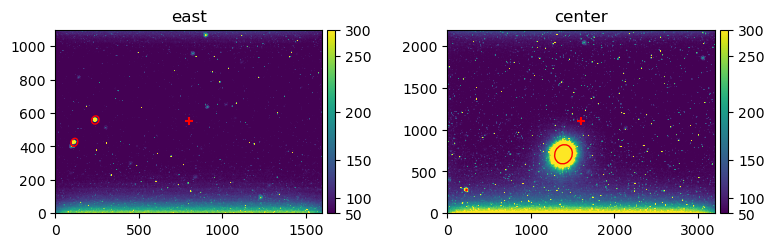

cam: east focus: 35.0 srcs: 2
cam: center focus: 35.0 srcs: 2


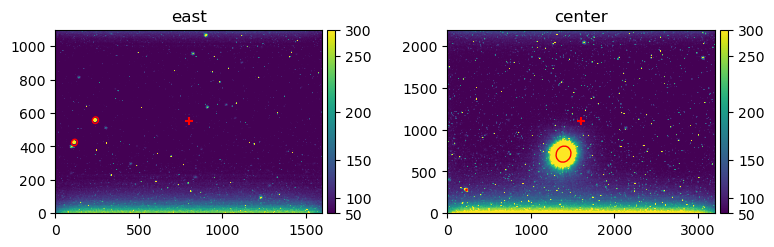

cam: east focus: 35.5 srcs: 6
cam: center focus: 35.5 srcs: 4


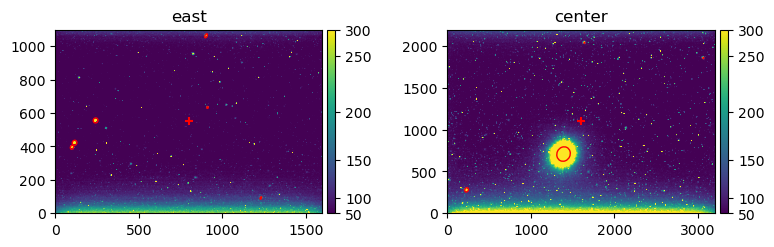

cam: east focus: 36.0 srcs: 9
cam: center focus: 36.0 srcs: 4


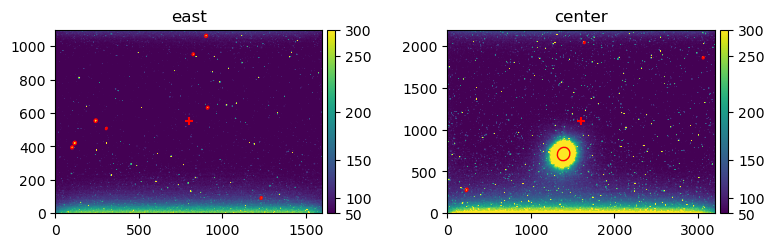

cam: east focus: 36.5 srcs: 10
cam: center focus: 36.5 srcs: 7


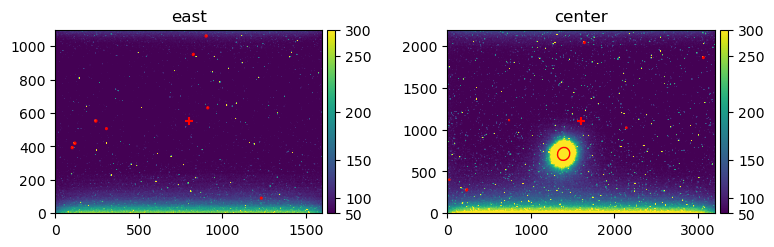

cam: east focus: 37.0 srcs: 11
cam: center focus: 37.0 srcs: 9


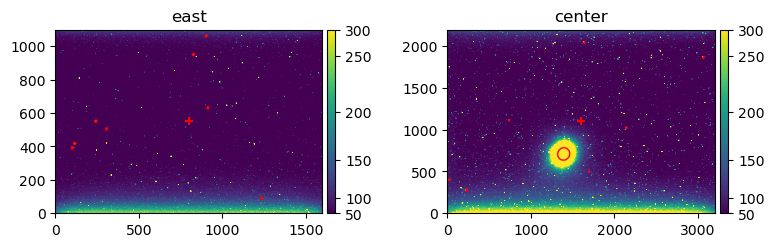

cam: east focus: 37.5 srcs: 10
cam: center focus: 37.5 srcs: 6


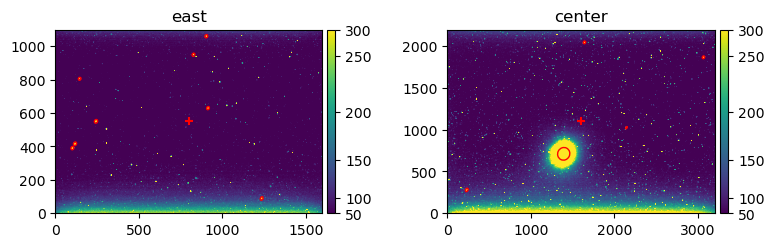

[[3.67773715e+01 3.55008079e-03]
 [3.67412228e+01 2.87742213e-02]]
[3.67592972e+01 1.61621510e-02]


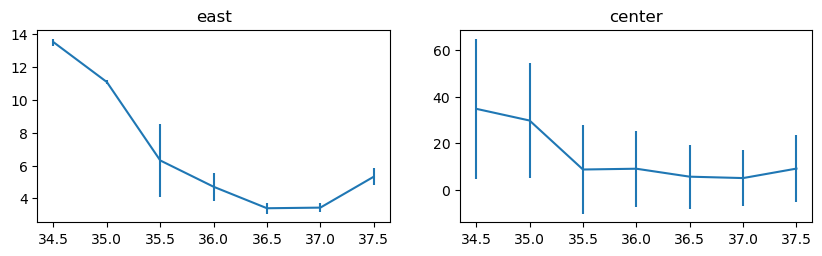

In [15]:
from lvmagp.focus.focusseries.base import FocusSeries
from lvmagp.focus.curvefit import fit_hyperbola
from lvmagp.images import Image

import matplotlib.pyplot as plt


def callback(data):
    if isinstance(data[0], Image):
        for idx, img in enumerate(data):
            print(f"cam: {img.header['CAMNAME']} focus: {img.header['FOCUSDT']} srcs: {len(img.catalog)}")
        plot_images(data)
    elif isinstance(data[0], tuple):
        fig, ax = plt.subplots(1, ncols=(len(data)), figsize=(10, 5/len(data)))

        for idx, d in enumerate(data):
            camera = d[0]
            dd = d[1]
            focus = [d["focus"] for d in dd]
            r = [d["r"] for d in dd]
            rerr = [d["rerr"] for d in dd]

            ax_idx = ax[idx] if len(data) > 1 else ax
            ax_idx.set_title(camera)
            ax_idx.errorbar(focus, r, yerr=rerr)

    
focvals = await focus.fine(exposure_time=5.0, guess=36, count=3, step=0.5, callback=callback)
print(focvals)
print(np.nanmean(focvals, axis=0))


In [18]:
await focus.position(36.7)
await lvm.sci.foc.status()

{'Reachable': True,
 'AtHome': False,
 'Moving': False,
 'PositionSwitchStatus': 0,
 'Position': 36.7,
 'DeviceEncoder': {'Position': -1650.0, 'Unit': 'STEPS'},
 'Velocity': 0.0,
 'AtLimit': False}